# 은행 이탈 데이터 셋을 이용한 이진 분류
Binary Classification with a Bank Churn Dataset

---

# 1. 문제 정의(개요)
은행 고객 이탈 예측 관련 데이터셋을 사용해 이진 분류 모델을 구축하는 것을 목적으로 합니다. 이 데이터셋에는 고객ID, 이름, 신용점수, 국가, 성별, 나이, 보유기간, 잔액, 제품 수, 신용카드 상태, 활성 멤버쉽, 예상 급여 및 이 데이터 셋의 메인 학습 라벨인 고객 이탈 여부 등 다양한 특성들이 포함되어 있습니다. 이 프로젝트는 데이터 탐색, 전처리, 모델 선택 및 훈련, 모델 평가, 결과 시각화, 배포의 단계로 진행됩니다. 주어진 데이터를 가지고 모델을 학습시켜 고객의 이탈 예측 및 방지를 목표로 두고 있습니다.

---

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 
import missingno as mno
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

# 2. 데이터 탐색 및 전처리
- train 데이터 컬럼
    - id: ID
    - CustomerId: 고객ID
    - Surname: 성(이름)
    - CreditScore: 신용점수
    - Geography: 지역(국가)
    - Gender: 성별
    - Age: 나이
    - Tenure: 가입기간
    - Balance: 잔액
    - NumOfProducts: 고객 보유 상품 수
    - HasCrCard: 신용카드 유무 (1: Yes, 0: No)
    - IsActiveMember: 활성 멤버쉽 (1: Yes, 0: No)
    - EstimatedSalary: 예상 급여
    - Exited: 이탈 유무(1: Yes, 0: No) => 타겟 컬럼

In [231]:
# 데이터 불러오기(train, test, submission)
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [232]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [233]:
test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [234]:
# 불필요한 컬럼 삭제
train.drop(['id', 'Surname'], axis=1, inplace=True)
test.drop(['id', 'Surname'], axis=1, inplace=True)

In [235]:
train.columns

Index(['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [236]:
test.columns

Index(['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary'],
      dtype='object')

In [237]:
# train 데이터 null값 확인
train.isnull().sum()

CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

<Axes: >

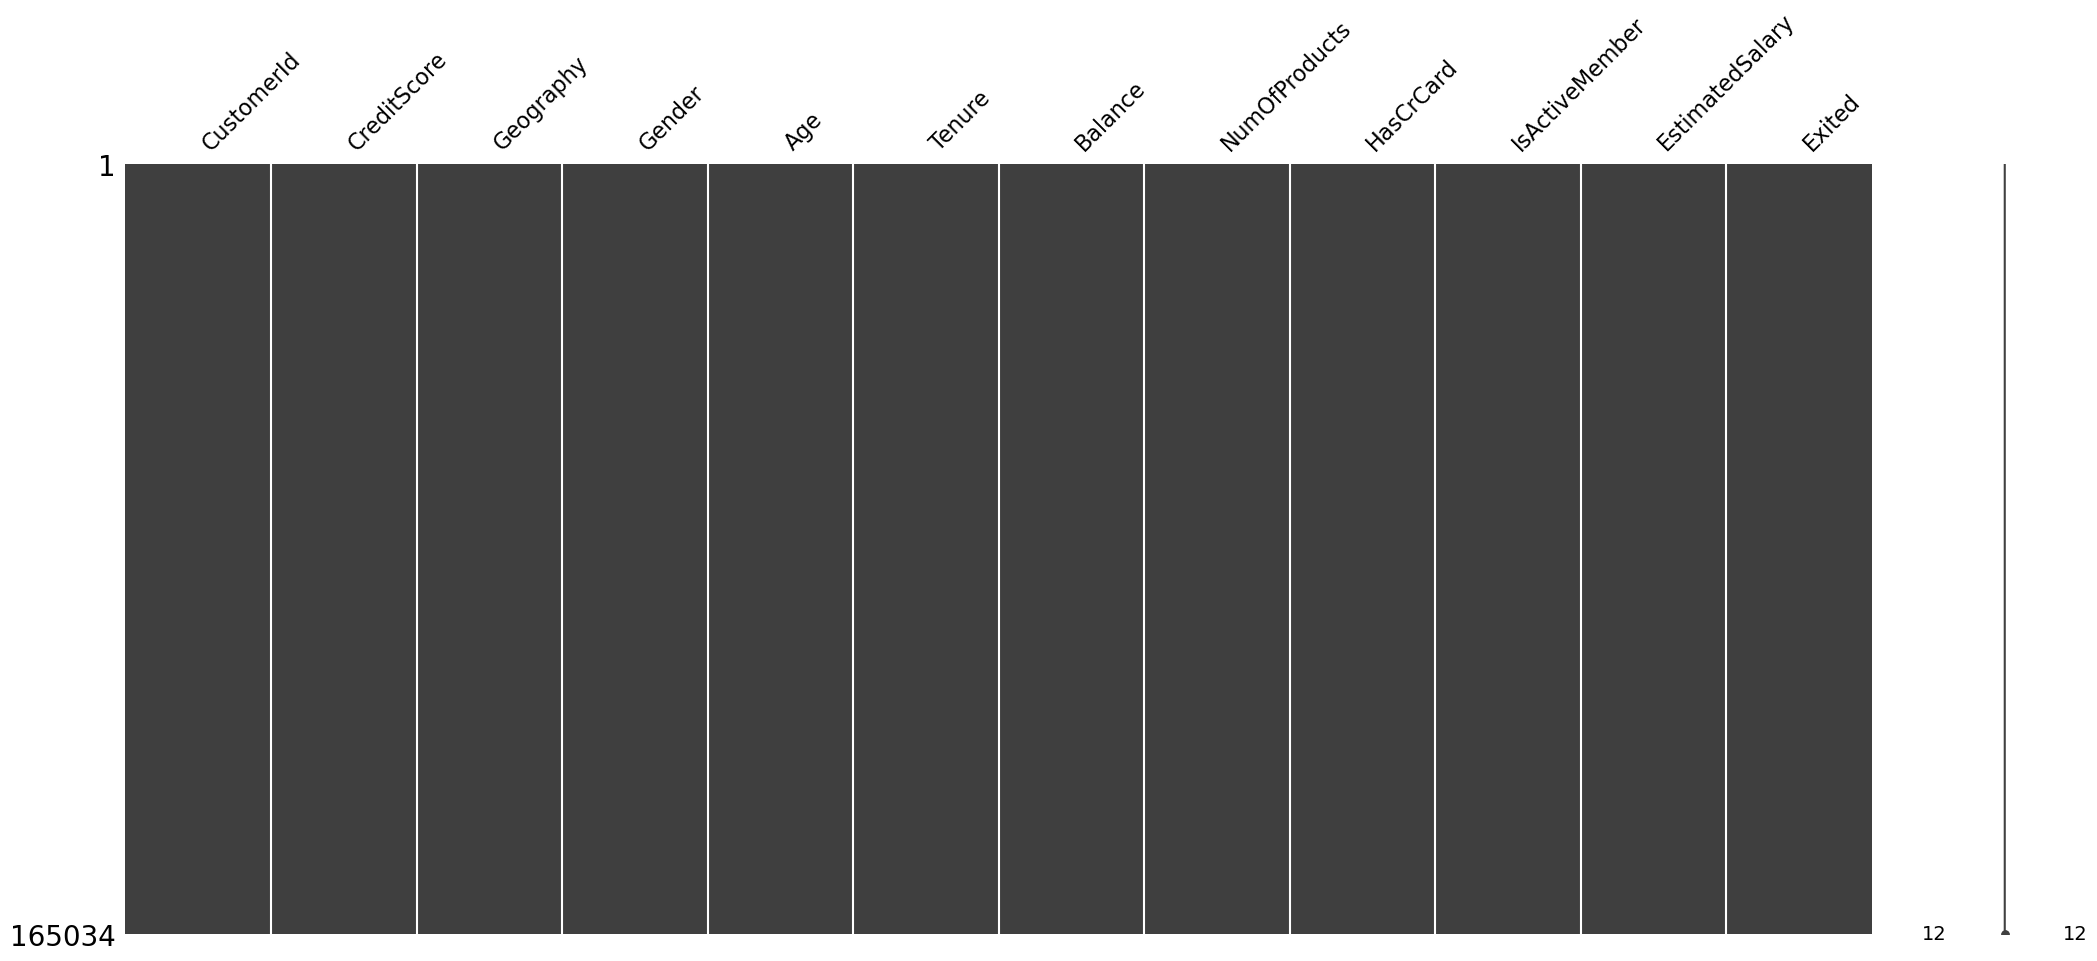

In [238]:
mno.matrix(train)


In [239]:
# test 데이터 null값 확인
test.isnull().sum()

CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

<Axes: >

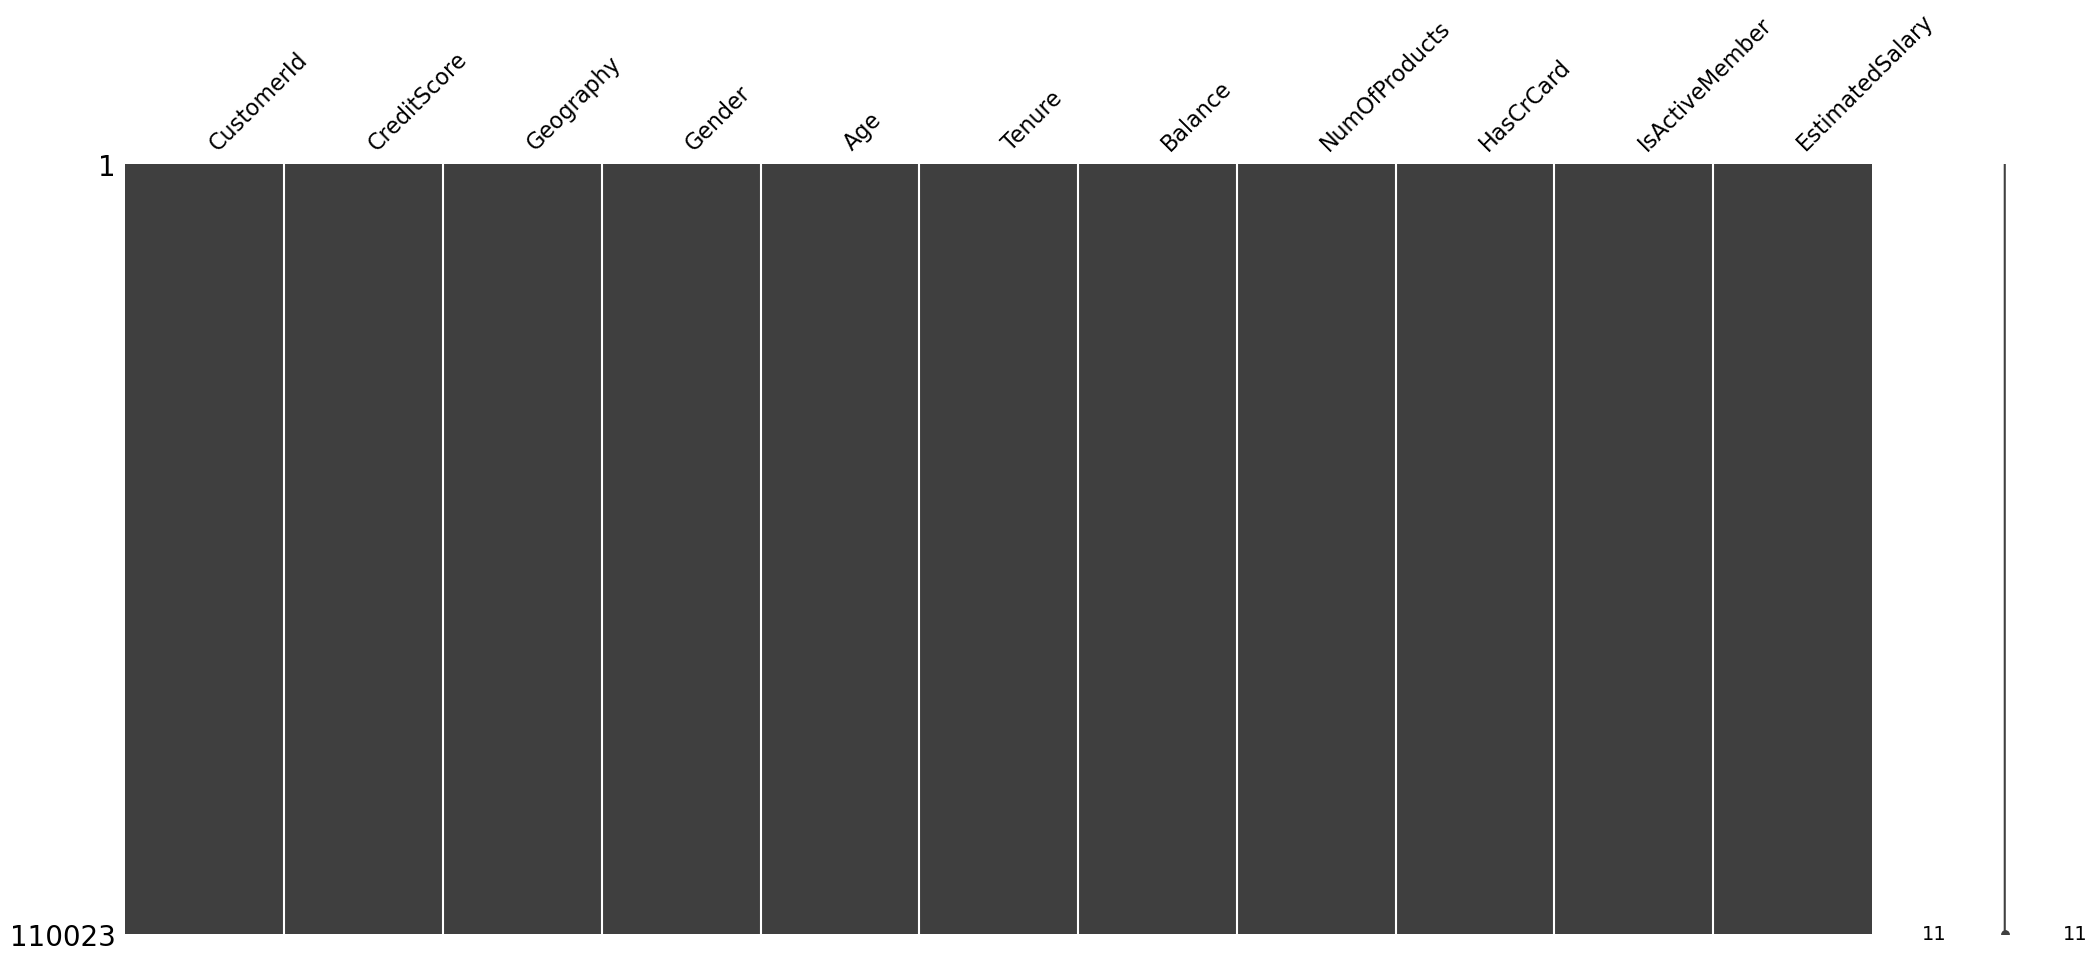

In [240]:
mno.matrix(test)


In [241]:
# train 데이터 중복값 제거
train.duplicated().sum()

30

In [242]:
train.drop_duplicates(inplace=True)

In [243]:
train.duplicated().sum()

0

In [244]:
# test 데이터 중복값 제거
test.duplicated().sum()

19

In [245]:
test.drop_duplicates(inplace=True)
test.duplicated().sum()

0

In [246]:
# train / test 데이터 크기 조회
train.shape

(165004, 12)

In [247]:
test.shape

(110004, 11)

In [248]:
# train / test 데이터 크기 및 비율 조회
print(f'Train data : {train.shape}')
print(f'Test data : {test.shape}')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data Percentage : {train_data_percentage * 100}%')
print(f'Test data Percentage : {(1- train_data_percentage) * 100}%')

Train data : (165004, 12)
Test data : (110004, 11)
Train data Percentage : 60.0%
Test data Percentage : 40.0%


In [249]:
# train 데이터 통계적 수치 확인
train.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,165004.0,1.569200e+07,71398.294444,15565701.00,1.563312e+07,15690165.5,15756824.00,15815690.00
CreditScore,165004.0,6.564580e+02,80.101397,350.00,5.970000e+02,659.0,710.00,850.00
Age,165004.0,3.812536e+01,8.866923,18.00,3.200000e+01,37.0,42.00,92.00
Tenure,165004.0,5.020515e+00,2.806134,0.00,3.000000e+00,5.0,7.00,10.00
Balance,165004.0,5.547720e+04,62817.816773,0.00,0.000000e+00,0.0,119948.09,250898.09
NumOfProducts,165004.0,1.554465e+00,0.547161,1.00,1.000000e+00,2.0,2.00,4.00
HasCrCard,165004.0,7.539332e-01,0.430719,0.00,1.000000e+00,1.0,1.00,1.00
IsActiveMember,165004.0,4.977394e-01,0.499996,0.00,0.000000e+00,0.0,1.00,1.00
EstimatedSalary,165004.0,1.125762e+05,50293.024195,11.58,7.463765e+04,117948.0,155155.25,199992.48
Exited,165004.0,2.116009e-01,0.408445,0.00,0.000000e+00,0.0,0.00,1.00


In [250]:
# Train 데이터 형식 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165004 entries, 0 to 165033
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165004 non-null  int64  
 1   CreditScore      165004 non-null  int64  
 2   Geography        165004 non-null  object 
 3   Gender           165004 non-null  object 
 4   Age              165004 non-null  float64
 5   Tenure           165004 non-null  int64  
 6   Balance          165004 non-null  float64
 7   NumOfProducts    165004 non-null  int64  
 8   HasCrCard        165004 non-null  float64
 9   IsActiveMember   165004 non-null  float64
 10  EstimatedSalary  165004 non-null  float64
 11  Exited           165004 non-null  int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 16.4+ MB


In [251]:
# 문자열 데이터인 Geography와 Gender 상세 개수 확인
train.Geography.value_counts()

Geography
France     94193
Spain      36209
Germany    34602
Name: count, dtype: int64

In [252]:
train.Gender.value_counts()

Gender
Male      93134
Female    71870
Name: count, dtype: int64

---

# 3. EDA 

In [253]:
# 범주형/수치형 컬럼 구분
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

array([[<Axes: title={'center': 'CreditScore'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'Balance'}>],
       [<Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'EstimatedSalary'}>]], dtype=object)

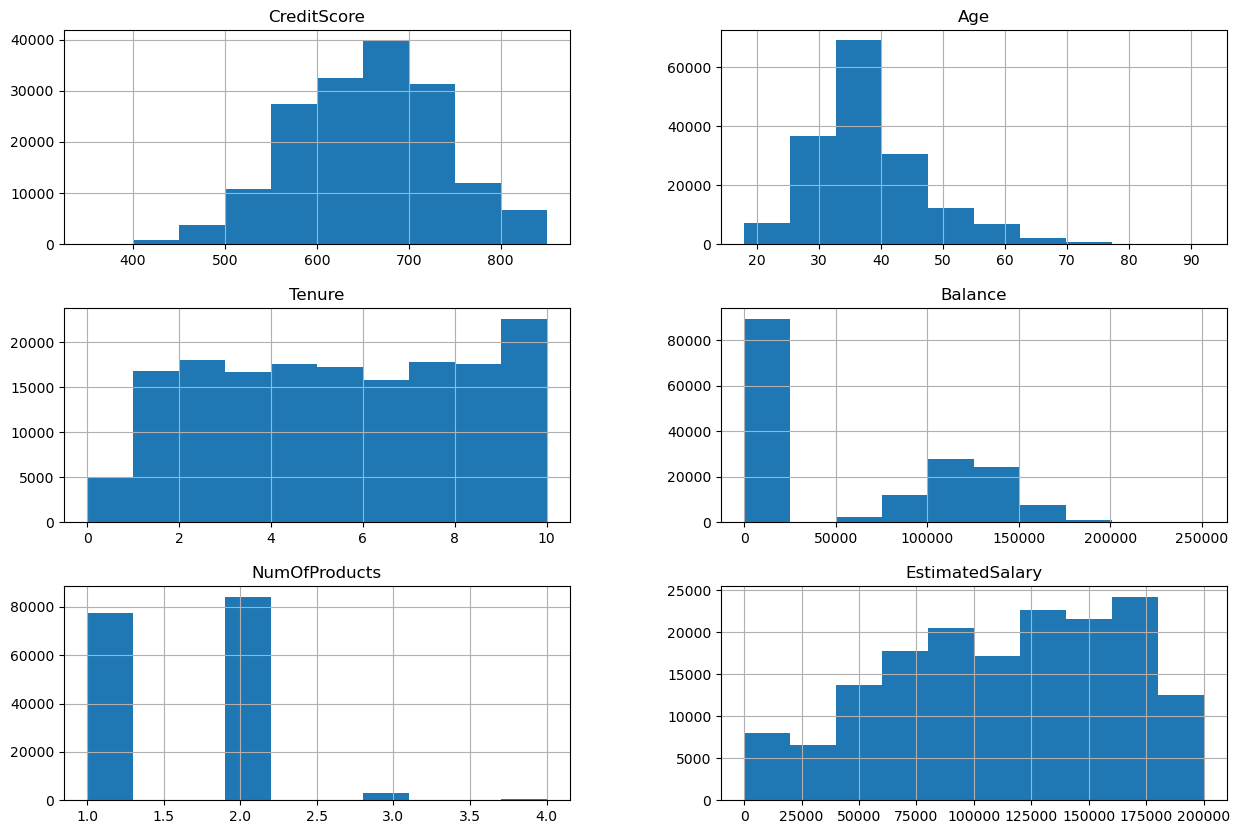

In [254]:
# 수치형 컬럼의 히스토그램 조사
train[num_cols].hist(bins=10, figsize=(15, 10))

### 수치형 컬럼 관찰 결과:
- 신용점수 분포는 600-700점 사이의 고객이 비교적 많습니다.
- 나이 분포는 30-40대에 많이 있습니다.
- 가입 기간으로는 1년 미만 고객의 분포가 가장 적고, 1년 이상 9년 이하 고객의 분포가 대부분이며, 9년이상 고객의 수가 가장 많습니다. 
- 잔액이 25000 미만인 고객이 가장 많습니다.
- 고객 보유 상품 수로는 2개를 가진 고객이 가장 많고, 다음으로는 1개를 가진 고객이 많습니다.
- 예상 급여로는 125000이상 175000미만 고객이 가장 많고, 50000이하인 고객이 비교적 적습니다.

In [255]:
# 수치형 데이터 상관관계 조사
num_cols_corr = train[num_cols].corr()
num_cols_corr

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
CreditScore,1.000000,-0.008881,0.000926,0.006952,0.011355,-0.001853
Age,-0.008881,1.000000,-0.010761,0.064347,-0.102169,-0.005445
Tenure,0.000926,-0.010761,1.000000,-0.009471,0.007342,0.001021
Balance,0.006952,0.064347,-0.009471,1.000000,-0.361012,0.008591
NumOfProducts,0.011355,-0.102169,0.007342,-0.361012,1.000000,-0.004294
EstimatedSalary,-0.001853,-0.005445,0.001021,0.008591,-0.004294,1.000000


<Axes: >

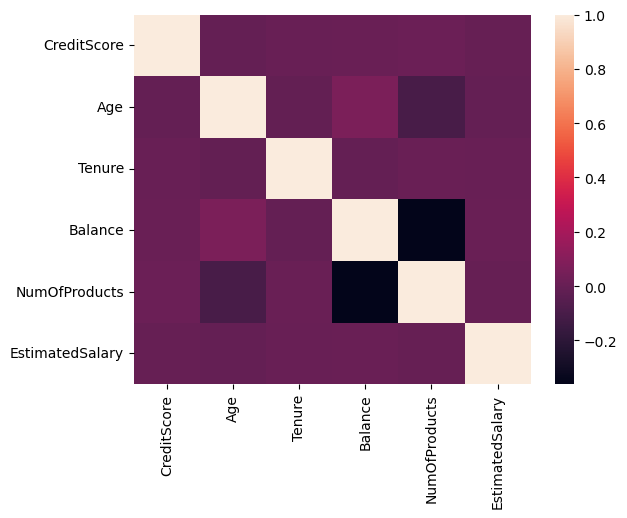

In [256]:
# 수치형 데이터 상관관계 히트맵
sns.heatmap(num_cols_corr)

<Axes: xlabel='NumOfProducts', ylabel='Balance'>

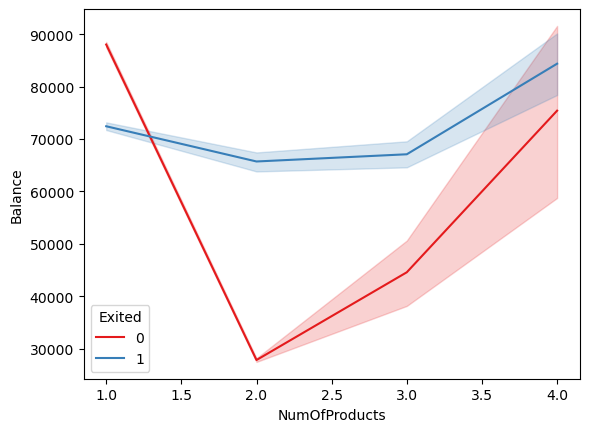

In [257]:
# 상관관계가 높은 두 수치형 데이터 간의 관계 시각화(lineplot)
# balance - 연속형(y축) / num of products - 이산형(x축) 
sns.lineplot(x='NumOfProducts', y='Balance', hue='Exited', data=train, palette='Set1')

### 수치형 데이터 상관관계 관찰 결과:
- 수치형 데이터 중 '고객 보유 상품 수'와 '잔액'이 비교적 높은 음의 상관관계를 가지고 있습니다.
- 상위 2개의 수치형 데이터를 시각화한 결과, 잔액이 60000이상이고, 대체로 상품을 3개 이상 보유한 고객의 이탈이 급격히 높아지는 것을 확인할 수 있습니다.

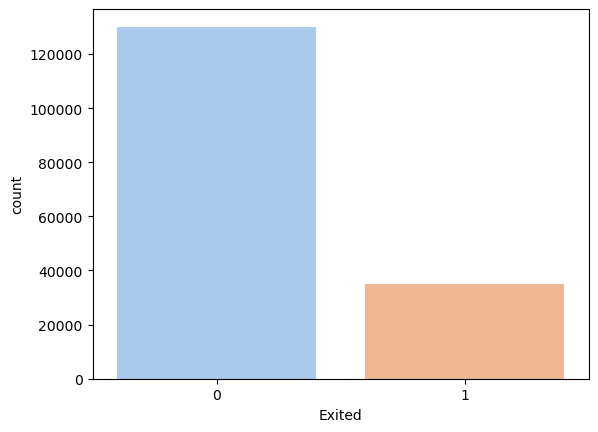

In [258]:
sns.countplot(train, x='Exited', palette='pastel')
plt.show();

##### 이탈하지 않는 고객 수가 이탈 고객 수보다 3배 이상 많습니다.

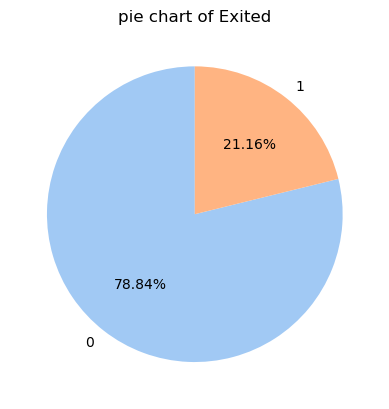

In [259]:
label_counts = train['Exited'].value_counts()

plt.pie(label_counts, labels=label_counts.index, autopct='%1.2f%%',  startangle=90, colors=sns.color_palette('pastel'))
plt.title('pie chart of Exited')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_17148\2028912407.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_17148\2028912407.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_17148\2028912407.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


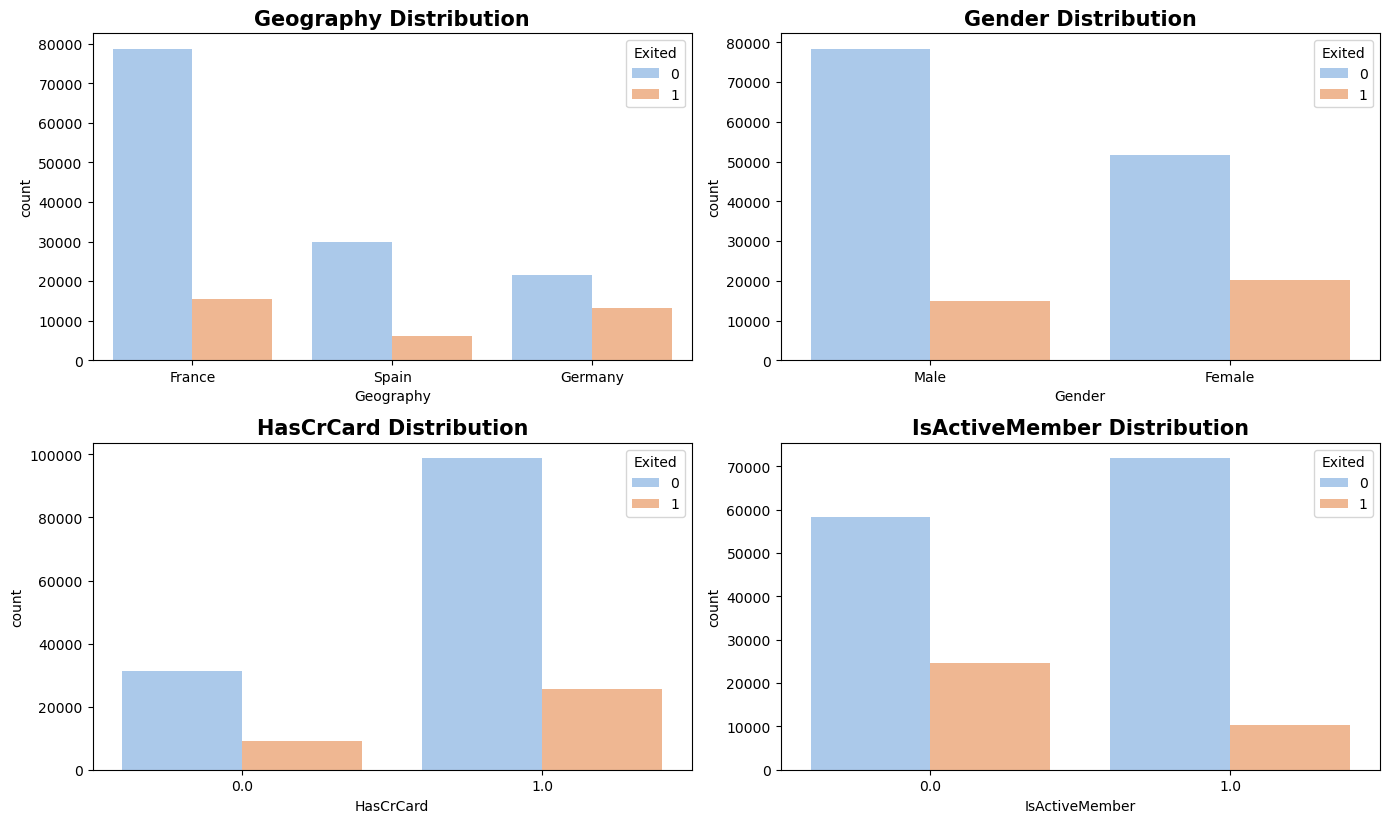

In [260]:
# 이탈 유무에 따른 범주형 컬럼 분포 조사
plt.figure(figsize=(14,len(cat_cols)*3))
for idx,column in enumerate(cat_cols):
    plt.subplot(len(cat_cols)//2+1,2,idx+1)
    sns.countplot(hue="Exited", x=column, data=train, palette="pastel")
    plt.title(f"{column} Distribution",weight='bold',fontsize=15)
    plt.tight_layout()

### 이탈 유무에 따른 범주형 컬럼 관찰 결과 :
- 지역 분포로 보면, 프랑스와 독일의 이탈 고객 수가 비슷하게 많았고, 스페인의 이탈 고객 수가 가장 적습니다.
- 성별 분포로 보면, 여성이 남성보다 이탈 고객 수가 많습니다.
- 신용카드 유무 분포로 보면, 신용카드를 소지한 고객의 이탈 수가 많으나, 이탈 하지 않는 수도 가장 많습니다.
- 활성 멤버 분포로 보면, 활성 멤버가 아닌 고객의 이탈 수가 많습니다.


,Exited,HasCrCard,count
0,0,1.0,98720
1,0,0.0,31369
2,1,1.0,25682
3,1,0.0,9233


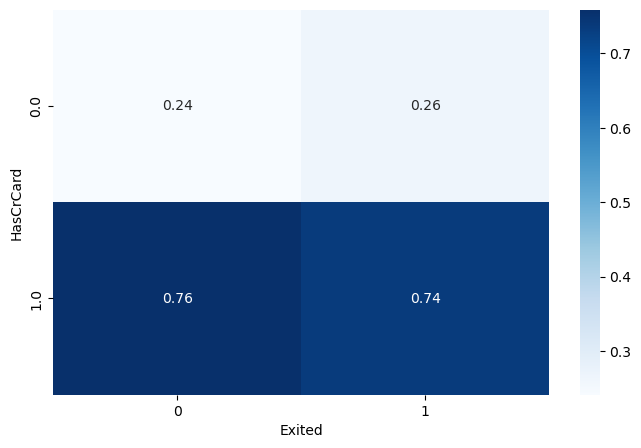

In [261]:
# 신용카드 유무
target_col = 'Exited'

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.despine()

val_cnt = train[[target_col, 'HasCrCard']].value_counts().reset_index()
pivot_table = val_cnt.pivot_table(index='HasCrCard', columns=target_col, values='count', aggfunc=sum, fill_value=0)

pivot_table = pivot_table / pivot_table.sum(axis=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Blues")
val_cnt

##### 신용카드를 소지한 고객의 이탈 가능성/이탈 하지 않을 가능성 모두 높은 것으로 나타납니다.

,Exited,IsActiveMember,count
0,0,1.0,71836
1,0,0.0,58253
2,1,0.0,24622
3,1,1.0,10293


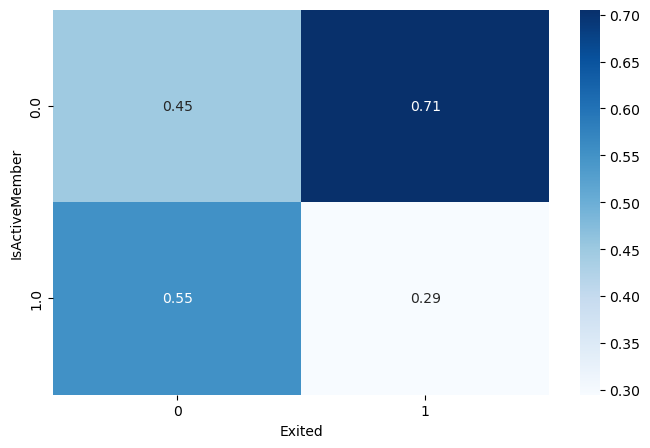

In [262]:
# 활성 멤버쉽 유무
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.despine()
val_cnt = train[[target_col, 'IsActiveMember']].value_counts().reset_index()
pivot_table = val_cnt.pivot_table(index='IsActiveMember', columns=target_col, values='count', aggfunc=sum, fill_value=0)

pivot_table = pivot_table / pivot_table.sum(axis=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='Blues')
val_cnt

##### 활성 멤버가 아닌 고객의 이탈 가능성이 더 높은 것으로 나타납니다.

,Exited,Gender,count
0,0,Male,78320
1,0,Female,51769
2,1,Female,20101
3,1,Male,14814


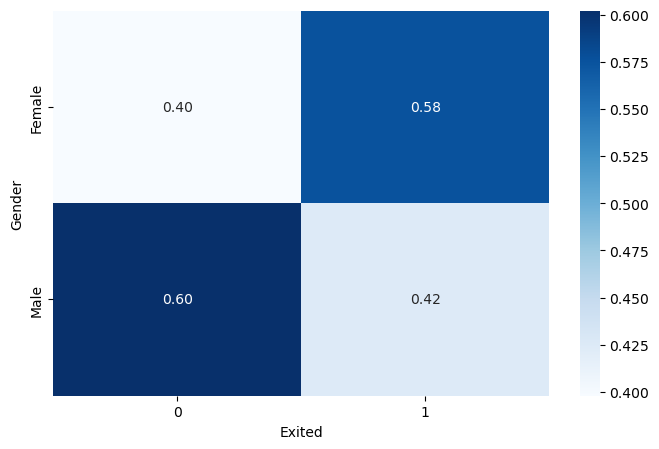

In [263]:
# 성별
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.despine()
val_cnt = train[[target_col, 'Gender']].value_counts().reset_index()
pivot_table = val_cnt.pivot_table(index='Gender', columns=target_col, values='count', aggfunc=sum, fill_value=0)

pivot_table = pivot_table / pivot_table.sum(axis=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='Blues')
val_cnt

##### 여성의 이탈 가능성이 더 높은 것으로 나타납니다.

,Exited,Geography,count
0,0,France,78622
1,0,Spain,29976
2,0,Germany,21491
3,1,France,15571
4,1,Germany,13111
5,1,Spain,6233


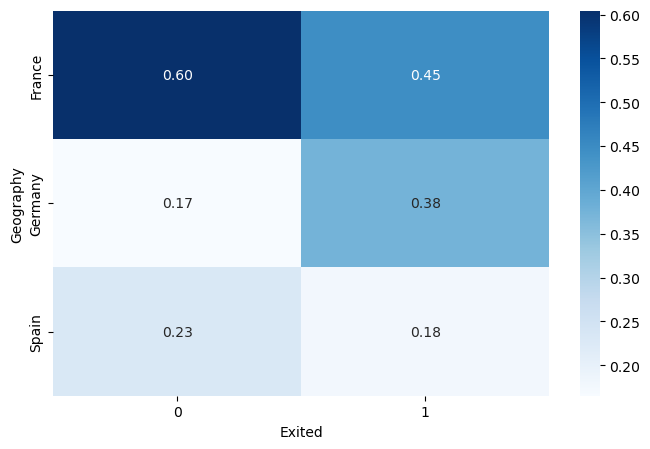

In [264]:
# 지역(국가)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.despine()
val_cnt = train[[target_col, 'Geography']].value_counts().reset_index()
pivot_table = val_cnt.pivot_table(index='Geography', columns=target_col, values='count', aggfunc=sum, fill_value=0)

pivot_table = pivot_table / pivot_table.sum(axis=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='Blues')
val_cnt

##### 프랑스 고객의 이탈 가능성이 가장 높게 나타났으나, 이탈 하지 않을 가능성도 가장 높게 나타납니다.

In [265]:
train_copy = train.copy()
train_copy.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [266]:
# 라벨 인코딩(Label Encoding)

def label_encoder(column):
    le = LabelEncoder().fit(column)
    return le.transform(column)

In [267]:
column = cat_cols

for col in column:
    train_copy[col] = label_encoder(train_copy[col])

<Axes: >

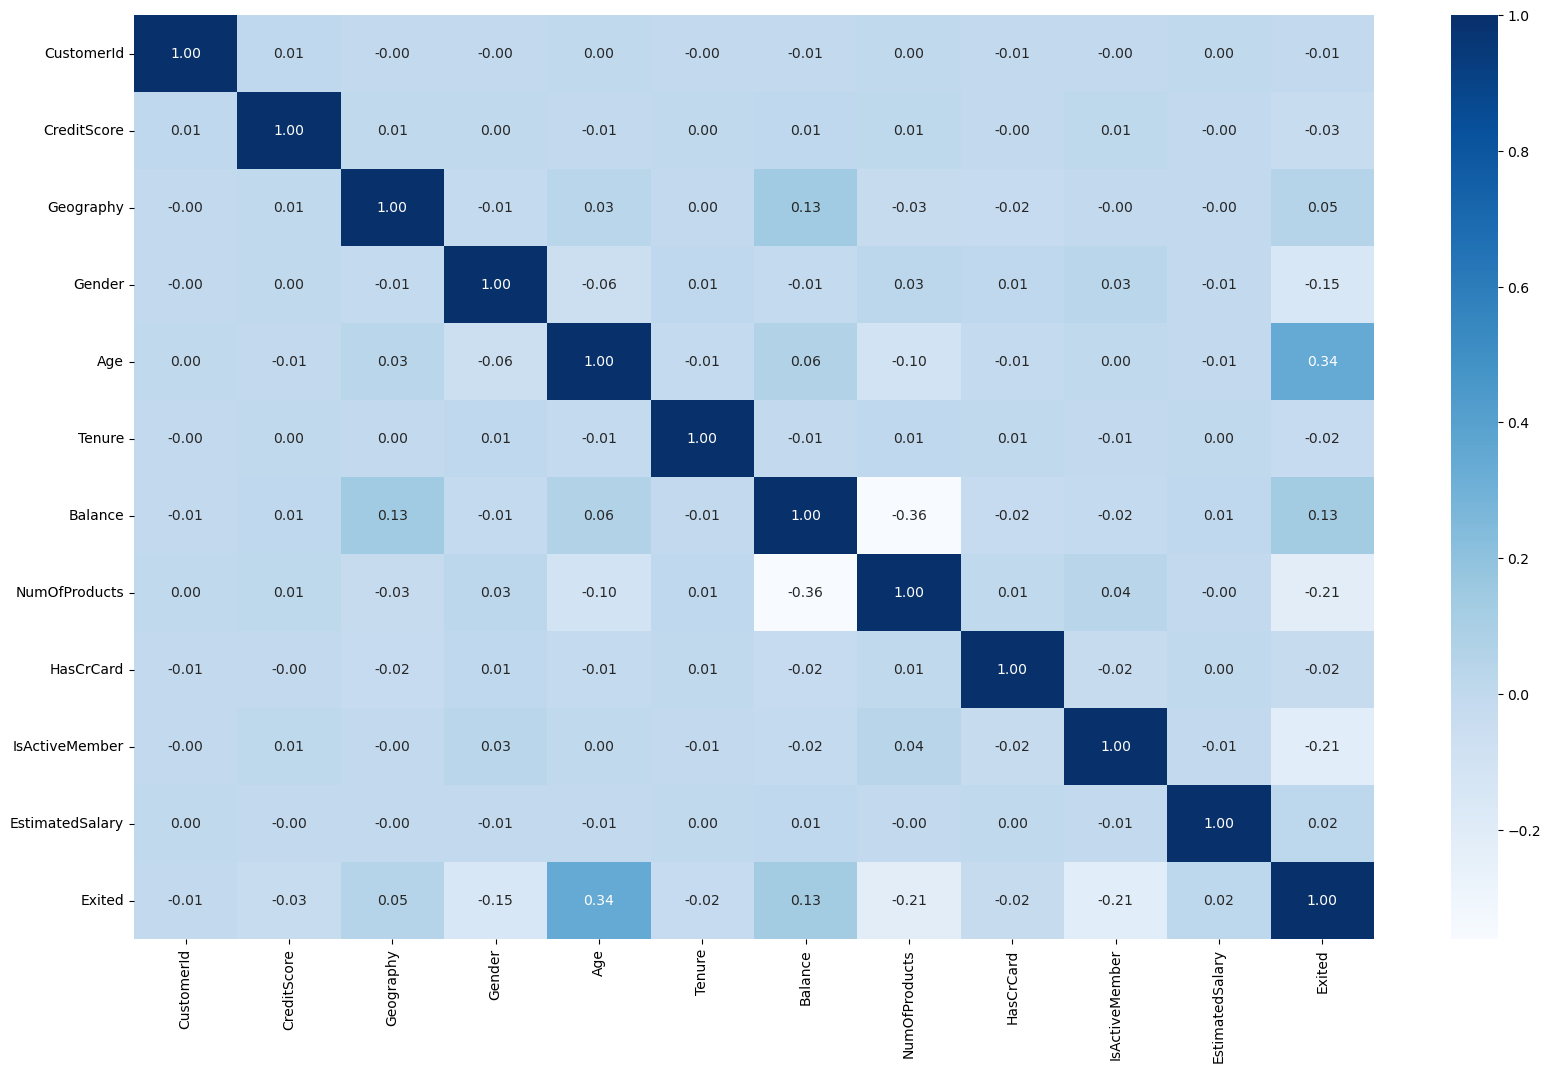

In [268]:
# 상관관계 히트맵
train_corr = train_copy.corr(method='pearson')
plt.figure(figsize=(20, 12))
sns.heatmap(train_corr, annot=True, fmt='.2f', cmap='Blues')

### 상관관계 히트맵 관찰:
- 이탈 유무('Exited')는 나이('Age'), 잔액('Balance')과 상관관계가 있습니다.

---

# EDA 결과 두드러진 특징:
- 지역: 프랑스와 독일의 이탈이 비교적 많음
- 성별: 여성의 이탈이 비교적 많음
- 활성 멤버: 활성 멤버가 아닌 고객의 이탈이 비교적 많음
- 이탈 유무는 나이, 잔액과의 상관관계가 비교적 높음
- 잔액이 6만 이상, 상품을 3개 이상 보유한 고객의 이탈이 비교적 높음


# 결과에 따른 궁금증(관련 기사 찾아보기):
- 왜 프랑스 독일의 이탈이 비교적 많은지?
- 왜 여성의 이탈이 남성보다 많은지?
- 연령대에 따른 고객 이탈
- 은행 잔고에 따른 고객 이탈
- 왜 잔액이 높을수록 고객 이탈이 많은지?

# 고객 이탈과 관계성 있는 feature(데이터 추가 탐색)
- 예적금 금리 변동 자료: 예적금 금리 올려 고객 이탈율 최소화(https://www.thepublic.kr/news/articleView.html?idxno=82082)
- 은행 마케팅 진행비: 은행 마케팅 진행 비용과 고객 이탈율 관계

---

# 4. Encoding

In [269]:
# one-hot encoding
train_encoding = pd.get_dummies(train, columns=['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'])
train_encoding.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0
0,15674932,668,33.0,3,0.00,2,181449.97,0,True,False,False,False,True,False,True,True,False
1,15749177,627,33.0,1,0.00,2,49503.50,0,True,False,False,False,True,False,True,False,True
2,15694510,678,40.0,10,0.00,2,184866.69,0,True,False,False,False,True,False,True,True,False
3,15741417,581,34.0,2,148882.54,1,84560.88,0,True,False,False,False,True,False,True,False,True
4,15766172,716,33.0,5,0.00,2,15068.83,0,False,False,True,False,True,False,True,False,True


---

# 5. Modeling
- Logistic Regression
- Decision Tree
- Random Forest
- LightBGM
- XGBoost
- CatBoost 

In [270]:
# X, y 데이터 설정
X = train_encoding.drop(['Exited'], axis=1)
y = train_encoding['Exited']

X.shape, y.shape

((165004, 16), (165004,))

In [271]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [272]:
# 나눈 데이터의 불균형 정도 확인

print(np.unique(y_train, return_counts=True)[1][1] / len(y_train) * 100, '%')

21.159806756592957 %


In [273]:
# 분류기의 성능을 return 하는 함수 작성

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)

    return acc, pre, re, f1, auc

In [274]:
# 성능 출력하는 함수 하나 더 작성

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)

    print('==> Confusion matrix')
    print(confusion)
    print('====================')

    print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc, pre))
    print('Recall : {0:.4f}, F1 : {1:.4f}'.format(re, f1, auc))


## Logistic Regression

In [275]:
%%time

lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train, y_train) 
lr_pred = lr_clf.predict(X_test)

print_clf_eval(y_test, lr_pred)

==> Confusion matrix
[[39027     0]
 [10475     0]]
Accuracy : 0.7884, Precision : 0.0000
Recall : 0.0000, F1 : 0.0000
CPU times: total: 375 ms
Wall time: 551 ms


c:\Users\User\miniconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree

In [276]:
%%time

dt_clf = DecisionTreeClassifier(random_state=13, max_depth=4)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

print_clf_eval(y_test, dt_pred)

==> Confusion matrix
[[37495  1532]
 [ 5737  4738]]
Accuracy : 0.8532, Precision : 0.7557
Recall : 0.4523, F1 : 0.5659
CPU times: total: 406 ms
Wall time: 791 ms


## Random Forest

In [277]:
%%time

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print_clf_eval(y_test, rf_pred)

==> Confusion matrix
[[37050  1977]
 [ 4823  5652]]
Accuracy : 0.8626, Precision : 0.7409
Recall : 0.5396, F1 : 0.6244
CPU times: total: 1min 9s
Wall time: 26.2 s


## LightGBM

In [278]:
%%time

lgbm_clf = LGBMClassifier(n_jobs=-1, n_estimators=1000, num_leaves=64, boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test)

print_clf_eval(y_test, lgbm_pred)


[LightGBM] [Info] Number of positive: 24440, number of negative: 91062
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1121
[LightGBM] [Info] Number of data points in the train set: 115502, number of used features: 16
==> Confusion matrix
[[36923  2104]
 [ 4667  5808]]
Accuracy : 0.8632, Precision : 0.7341
Recall : 0.5545, F1 : 0.6318
CPU times: total: 27.9 s
Wall time: 10.1 s


## XGBoost

In [279]:
%%time

xgb_clf = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

print_clf_eval(y_test, xgb_pred)


==> Confusion matrix
[[37144  1883]
 [ 4728  5747]]
Accuracy : 0.8664, Precision : 0.7532
Recall : 0.5486, F1 : 0.6349
CPU times: total: 8.36 s
Wall time: 2.88 s


## CatBoost

In [280]:
%%time

cat_clf = CatBoostClassifier(learning_rate=0.1, max_depth=5, verbose=50)
cat_clf.fit(X_train, y_train)
cat_pred = cat_clf.predict(X_test)

print_clf_eval(y_test, cat_pred)


0:	learn: 0.6049100	total: 18.8ms	remaining: 18.7s
50:	learn: 0.3225365	total: 1.42s	remaining: 26.4s
100:	learn: 0.3191836	total: 2.56s	remaining: 22.8s
150:	learn: 0.3169209	total: 3.76s	remaining: 21.2s
200:	learn: 0.3148419	total: 5.05s	remaining: 20.1s
250:	learn: 0.3130866	total: 6.2s	remaining: 18.5s
300:	learn: 0.3114445	total: 7.57s	remaining: 17.6s
350:	learn: 0.3099954	total: 8.99s	remaining: 16.6s
400:	learn: 0.3085150	total: 10.4s	remaining: 15.5s
450:	learn: 0.3070680	total: 11.6s	remaining: 14.1s
500:	learn: 0.3057425	total: 12.8s	remaining: 12.7s
550:	learn: 0.3043687	total: 14.4s	remaining: 11.8s
600:	learn: 0.3030245	total: 15.9s	remaining: 10.5s
650:	learn: 0.3018041	total: 17.3s	remaining: 9.25s
700:	learn: 0.3005862	total: 19.1s	remaining: 8.16s
750:	learn: 0.2994022	total: 21s	remaining: 6.96s
800:	learn: 0.2982749	total: 22.8s	remaining: 5.65s
850:	learn: 0.2971284	total: 24.6s	remaining: 4.31s
900:	learn: 0.2960543	total: 26.5s	remaining: 2.91s
950:	learn: 0.295

In [281]:
# 모델과 데이터를 주면 성능을 출력하는 함수
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    return get_clf_eval(y_test, pred)

In [282]:
# 다수의 모델의 성능을 정리해서 DataFrame으로 반환하는 함수
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['Accuracy', 'Precision',  'Recall',  'F1',  'Roc_Auc']
    tmp = []

    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))

    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [283]:
# 6개의 분류 모델을 한번에 표로 정리
models = [lr_clf, dt_clf, rf_clf, lgbm_clf, xgb_clf, cat_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGB', 'CatBoost']
 
result = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
result

c:\Users\User\miniconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Info] Number of positive: 24440, number of negative: 91062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1121
[LightGBM] [Info] Number of data points in the train set: 115502, number of used features: 16
0:	learn: 0.6049100	total: 25.2ms	remaining: 25.2s
50:	learn: 0.3225365	total: 1.64s	remaining: 30.6s
100:	learn: 0.3191836	total: 3.09s	remaining: 27.5s
150:	learn: 0.3169209	total: 5.09s	remaining: 28.6s
200:	learn: 0.3148419	total: 7.01s	remaining: 27.9s
250:	learn: 0.3130866	total: 8.61s	remaining: 25.7s
300:	learn: 0.3114445	total: 10.3s	remaining: 23.9s
350:	learn: 0.3099954	total: 11.7s	remaining: 21.7s
400:	learn: 0.3085150	total: 14s	remaining: 21s
450:	learn: 0.3070680	total: 15.4s	remaining: 18.7s
500:	learn: 0.3057425	total: 17s	remaining: 16.9s
550:	learn: 0.3043687	total: 18.8s	remaining: 15.3s
600:	learn: 0.3030245	t

,Accuracy,Precision,Recall,F1,Roc_Auc
LogisticRegression,0.788392,0.000000,0.000000,0.000000,0.500000
DecisionTree,0.853157,0.755662,0.452315,0.565900,0.706530
RandomForest,0.862632,0.740857,0.539570,0.624392,0.744457
LightBGM,0.863218,0.734075,0.554463,0.631751,0.750276
XGB,0.866450,0.753211,0.548640,0.634852,0.750195
CatBoost,0.866066,0.751143,0.548926,0.634308,0.750057


## ROC Curve 그리기

In [284]:
# 모델별 roc 커브

def draw_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 10))

    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1] 
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label=model_names[model])

    plt.plot([0, 1],[0, 1], 'k--', label='random guess') 
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

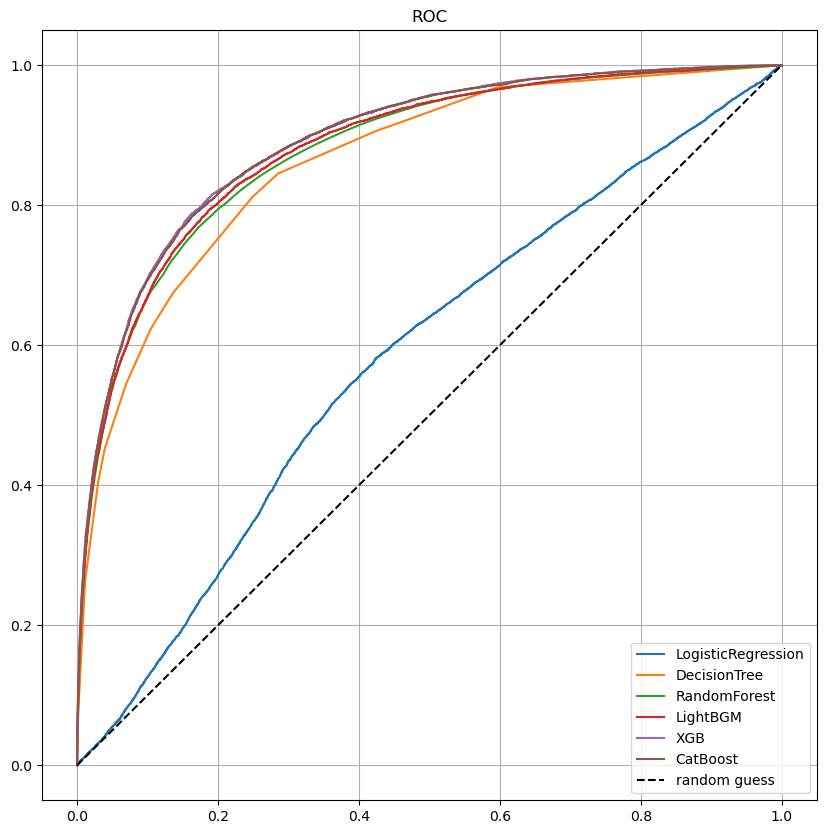

In [285]:
draw_roc_curve(models, model_names, X_test, y_test)

---

## 5.1 over sampling

In [286]:
smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [287]:
X_train.shape, y_train.shape

((115502, 16), (115502,))

In [288]:
X_train_over.shape, y_train_over.shape

((182124, 16), (182124,))

In [289]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train_over, return_counts=True))

(array([0, 1], dtype=int64), array([91062, 24440], dtype=int64))
(array([0, 1], dtype=int64), array([91062, 91062], dtype=int64))


---

## 5.2 오버샘플링 작업 후 다시 모델링


In [290]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf, xgb_clf, cat_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGB', 'CatBoost']
 
result = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
result

[LightGBM] [Info] Number of positive: 91062, number of negative: 91062
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1309
[LightGBM] [Info] Number of data points in the train set: 182124, number of used features: 16
0:	learn: 0.5874415	total: 48ms	remaining: 48s
50:	learn: 0.2343676	total: 2.68s	remaining: 49.9s
100:	learn: 0.2267734	total: 4.71s	remaining: 41.9s
150:	learn: 0.2189845	total: 6.84s	remaining: 38.5s
200:	learn: 0.2150626	total: 9.07s	remaining: 36s
250:	learn: 0.2114116	total: 11.1s	remaining: 33.2s
300:	learn: 0.2097811	total: 13.3s	remaining: 30.9s
350:	learn: 0.2076676	total: 15.4s	remaining: 28.5s
400:	learn: 0.2065348	total: 17.5s	remaining: 26.1s
450:	learn: 0.2053372	total: 19.6s	remaining: 23.9s
500:	learn: 0.2040543	total: 21.8s	remaining: 21.7s
550:	learn:

,Accuracy,Precision,Recall,F1,Roc_Auc
LogisticRegression,0.747748,0.437547,0.672840,0.530264,0.720347
DecisionTree,0.832896,0.601101,0.625203,0.612915,0.756922
RandomForest,0.861198,0.711751,0.578234,0.638083,0.757690
LightBGM,0.863682,0.728286,0.567542,0.637944,0.755355
XGB,0.866571,0.724843,0.595513,0.653844,0.767419
CatBoost,0.866389,0.742190,0.564773,0.641440,0.756059


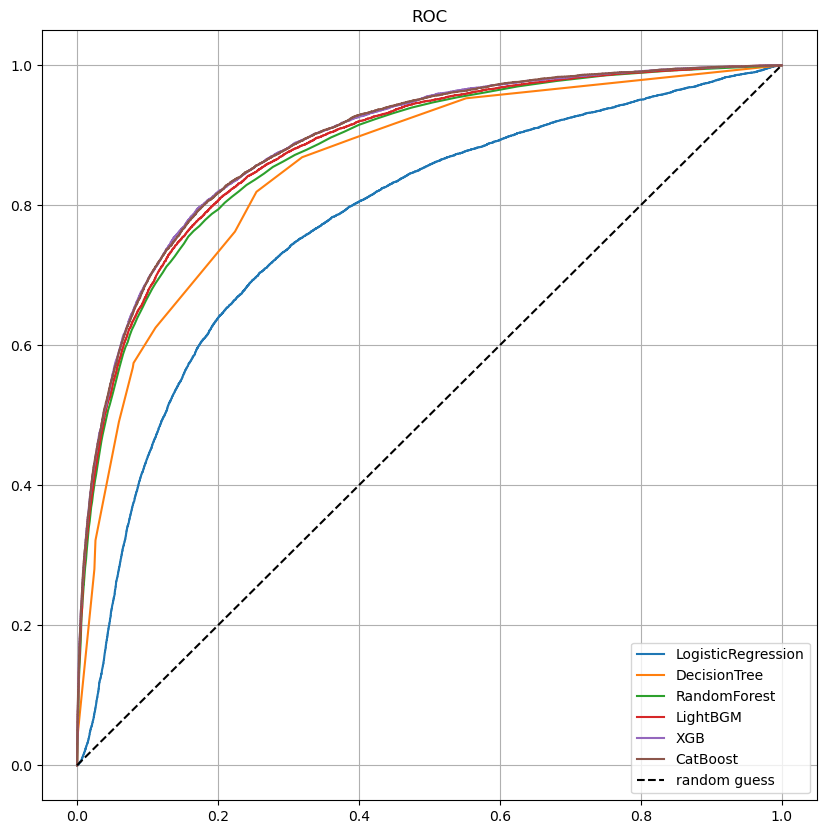

In [291]:
draw_roc_curve(models, model_names, X_test, y_test)

---

### 성능결과 :
XGB = Catboost = LightGBM = Random Forest > Decision Tree > Logistic Regression 
### 오버샘플링 전/후 roc 곡선 결과 비교
- Logistic Regression 성능 급격히 향상

---

# 6. 최적의 파라미터값 구하기(GridSearchCV)

#### Decision Tree

In [294]:
params = {
    'max_depth': [2, 4, 7, 10]
}

grid = GridSearchCV(dt_clf, param_grid=params, cv=3)
grid.fit(X_train_over, y_train_over)


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=4, random_state=13),
             param_grid={'max_depth': [2, 4, 7, 10]})

In [295]:
# best score 체크
print(f'grid.best_score: {grid.best_score_}')

# best params 체크
print(f'grid.best_params: {grid.best_params_}')

# test 데이터에서의 성능
print(f'accuracy score of test data: {accuracy_score(y_test, grid.best_estimator_.predict(X_test))}')

grid.best_score: 0.8606224330675802
grid.best_params: {'max_depth': 10}
accuracy score of test data: 0.8607126984768292


#### LightGBM

In [296]:
params = {
    'n_estimator' : [100, 500],
    'learning_rate' : [0.05, 0.1] 
}

grid = GridSearchCV(lgbm_clf, param_grid=params, cv=2, verbose=1, n_jobs=-1)
grid.fit(X_train_over, y_train_over)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Info] Number of positive: 91062, number of negative: 91062
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1309
[LightGBM] [Info] Number of data points in the train set: 182124, number of used features: 16


GridSearchCV(cv=2,
             estimator=LGBMClassifier(boost_from_average=False,
                                      n_estimators=1000, n_jobs=-1,
                                      num_leaves=64),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1],
                         'n_estimator': [100, 500]},
             verbose=1)

In [297]:
# best score 체크
print(f'grid.best_score: {grid.best_score_}')

# best params 체크
print(f'grid.best_params: {grid.best_params_}')

# test 데이터에서의 성능
print(f'accuracy score of test data: {accuracy_score(y_test, grid.best_estimator_.predict(X_test))}')

grid.best_score: 0.8463354637499725
grid.best_params: {'learning_rate': 0.05, 'n_estimator': 100}
[LightGBM] [Warning] Unknown parameter: n_estimator
accuracy score of test data: 0.8642277079713951


---

### 하이퍼파라미터 튜닝 후 성능 변화(Decision Tree, LightGBM):
- Decision Tree, LightGBM 모두 성능 소폭 향상 